In [6]:
from scipy import integrate, interpolate
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv
from PIL import Image
import re

from numba import jit, njit, prange

In [27]:
move_to_interval(3,5,8)

6

In [8]:
@njit
def where_on_interval(x, x_min, x_max):
    return ((x-x_min) / (x_max-x_min)) % 1.0
@njit
def move_to_interval(x, x_min, x_max):
    return (x-x_min) % (x_max-x_min) + x_min


@njit
def get_wormhole_view(phi0_data, phi1_data, sl_data, phi, theta, fov, resolution, r1, r2, skybox_arr1, skybox_arr2):
    def interpolate_data(phi0, data): # linear interpolation
        xr = phi0_data
        yr = data

        index = 0
        for i, xi in enumerate(xr):
            if phi0 < xi:
                index = i-1
                break
        return yr[index] + (yr[index+1]-yr[index])/(xr[index+1]-xr[index]) * (phi0 - xr[index])
    def get_deflection(phi):
        cphi = move_to_interval(phi, -np.pi, np.pi)
        return interpolate_data(cphi, phi1_data), interpolate_data(cphi, sl_data)
    def get_pixel(phi, th, sl):
        if sl>0:
            r = r1
            image_arr = skybox_arr1
            #return [255,255,255] # debug
        else:
            r = r2
            image_arr = skybox_arr2
            #return [0,0,0] # debug
        
        x = where_on_interval(phi+r, -np.pi, np.pi)
        # x = (phi+np.pi)/(2*np.pi) # normalised from 0-1
        y = where_on_interval(th, 0, np.pi)

        th_max = len(image_arr)
        phi_max = len(image_arr[0])
        return image_arr[int(y*(th_max-1))][int(x*(phi_max-1))]
    width = resolution[0]
    height = resolution[1]
    
    Dphi = fov
    Dth = height/width * fov
    
    # distance to the screen
    dist = width/(2*np.tan(Dphi/2))
    pixel_arr = np.zeros((height,width,3))
    for y in prange(height):
        for x in prange(width):                
            # centered coordinates
            xp = x-width/2
            yp = y-height/2

            dphi = np.arctan(xp/dist)
            dth = np.arctan(yp/dist)

            pphi = phi+dphi
            pth = theta+dth

            alpha = np.arctan2(np.sqrt(np.sin(pth)**2*np.sin(pphi)**2 + np.cos(pth)**2), np.sin(pth)*np.cos(pphi))

            alpha_prime, sl = get_deflection(alpha)
            phi_prime = np.arctan2(np.sin(alpha_prime)/np.sin(pth), np.cos(alpha_prime)/np.sin(pth))
            
            pixel_arr[y][x] = get_pixel(phi_prime, pth, sl)
    return pixel_arr

class WormholeViewer:
    def __init__(self, phi_file, back1, back2, rotate1=0, rotate2=0): 
        self.image_arr1 = np.array(Image.open(back1))
        self.image_arr2 = np.array(Image.open(back2))
        self.import_phifile(phi_file)

        self.r1 = rotate1
        self.r2 = rotate2

    def import_phifile(self, filename):
        phi0_arr = []
        phi1_arr = []
        sl_arr = []
        with open(filename, 'r') as rfile:
            lines = rfile.readlines()
            re_patt = r"(-*[0-9]+.[0-9]+)\t(-*[0-9]*.[0-9]*)\t(-*[0-9]*.[0-9]*e*[+-]*[0-9]+)\t(-*[0-9]*.[0-9]*e*[+-]*[0-9]+)\t(-*[01].0)"
            # pattern = re.compile(re_patt)
            for line in lines:
                matches = re.match(re_patt, line)
                if not matches:
                    continue

                th0 = float(matches.groups()[0])
                if (np.abs(th0-np.pi/2)<np.pi/30):                    
                    phi0 = float(matches.groups()[1])
                    # th1 = float(matches.groups()[3])
                    phi1 = float(matches.groups()[2])
                    sl = float(matches.groups()[4]) 
                    # th0_arr.append(th0)
                    phi0_arr.append(phi0)
                    #th1_arr.append(th1)
                    phi1_arr.append(phi1)
                    sl_arr.append(sl)
        self.phi0_arr = phi0_arr
        self.phi1_arr = phi1_arr
        self.sl_arr = sl_arr
        self.f_phi = interpolate.interp1d(phi0_arr, phi1_arr)
        self.f_sl = interpolate.interp1d(phi0_arr, sl_arr)


    def get_deflection(self, phi):
        cphi = move_to_interval(phi, -np.pi, np.pi)
        try:
            return self.f_phi(cphi), self.f_sl(cphi)
        except ValueError:
            print(f"{cphi=}, {phi=}")
            raise ValueError("Out of bounds")
    def get_pixel(self, phi, th, sl):


        if sl>0:
            r = self.r1
            image_arr = self.image_arr1 
            #return [255,255,255] # debug
        else:
            r = self.r2
            image_arr = self.image_arr2
            #return [0,0,0] # debug
        
        x = where_on_interval(phi+r, -np.pi, np.pi)
        # x = (phi+np.pi)/(2*np.pi) # normalised from 0-1
        y = where_on_interval(th, 0, np.pi)
        # print(f"{x=}, {y=}\n")
        # print(f"int: {int(y*self.th_max)}, {int(x*self.phi_max)}")
        th_max = len(image_arr)
        phi_max = len(image_arr[0])



        return image_arr[int(y*(th_max-1))][int(x*(phi_max-1))]
    
    def view_wormhole(self, phi0=0, th0=np.pi/2, fov=2/3*np.pi, resolution=(640,480)):
        width = resolution[0]
        height = resolution[1]
        
        Dphi = fov
        Dth = height/width * fov
        
        # distance to the screen
        dist = width/(2*np.tan(Dphi/2))
        pixel_arr = np.zeros((height,width,3))
        for y in range(height):
            for x in range(width):                
                # centered coordinates
                xp = x-width/2
                yp = y-height/2

                dphi = np.arctan(xp/dist)
                dth = np.arctan(yp/dist)

                pphi = phi0+dphi
                pth = th0+dth

                alpha = np.arctan2(np.sqrt(np.sin(pth)**2*np.sin(pphi)**2 + np.cos(pth)**2), np.sin(pth)*np.cos(pphi))

                alpha_prime, sl = self.get_deflection(alpha)
                phi_prime = np.arctan2(np.sin(alpha_prime)/np.sin(pth), np.cos(alpha_prime)/np.sin(pth))
                
                pixel_arr[y][x] = self.get_pixel(phi_prime, pth, sl)
        
        return Image.fromarray(np.uint8(pixel_arr))

    def view_wormhole_fast(self, phi0=0, th0=np.pi/2, fov=2/3*np.pi, resolution=(640,480)):
        pixel_arr = get_wormhole_view(self.phi0_arr,self.phi1_arr, self.sl_arr, phi0, th0, fov, resolution, self.r1, self.r2, self.image_arr1, self.image_arr2)
        return Image.fromarray(np.uint8(pixel_arr))


def view_wormhole(phi, th):
    pass


In [20]:
viewer = WormholeViewer(r"angle_data\angle_data3.dat", r"horizons\saturn_horizon.jpg", r"horizons\wormhole_horizon.jpg", rotate2=np.pi*0, rotate1=np.pi*0) 

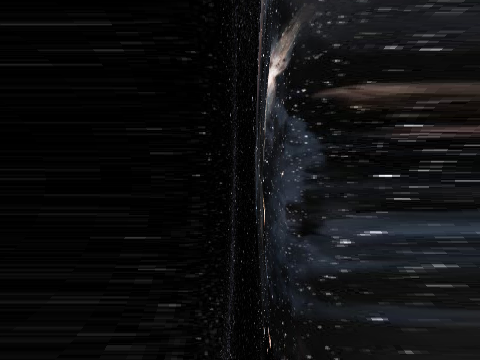

In [11]:
viewer.view_wormhole(phi0=np.pi*0.5, th0=np.pi*5/10, fov=np.pi*7/12, resolution=(160*3,120*3))

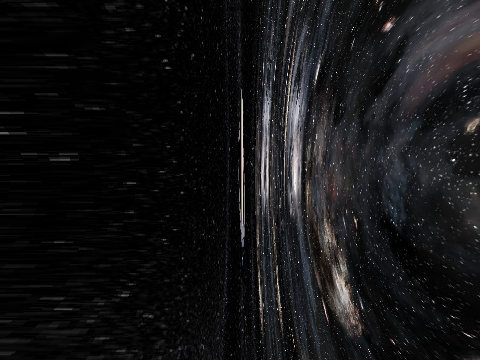

In [21]:
viewer.view_wormhole_fast(phi0=np.pi*0.5, th0=np.pi*5/10, fov=np.pi*7/12, resolution=(160*3,120*3))

In [24]:
from ipywidgets import interact, interactive, FloatSlider


interact(lambda phi, theta, fov: viewer.view_wormhole_fast(phi0=phi, th0=theta, fov=fov, resolution=(720,480)), 
         phi=FloatSlider(np.pi/2, min=-np.pi, max=np.pi), theta=FloatSlider(np.pi/2, min=0, max=np.pi), fov=FloatSlider(np.pi/2, min=np.pi/3, max=np.pi*2/3))

interactive(children=(FloatSlider(value=1.5707963267948966, description='phi', max=3.141592653589793, min=-3.1…

<function __main__.<lambda>(phi, theta, fov)>

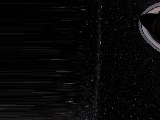

In [281]:
img = viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*6/10, fov=np.pi*6/12,resolution=(160,120))
img

In [ ]:
img = viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*7/10, fov=np.pi*6/12, resolution=(1280,720))
img.show()

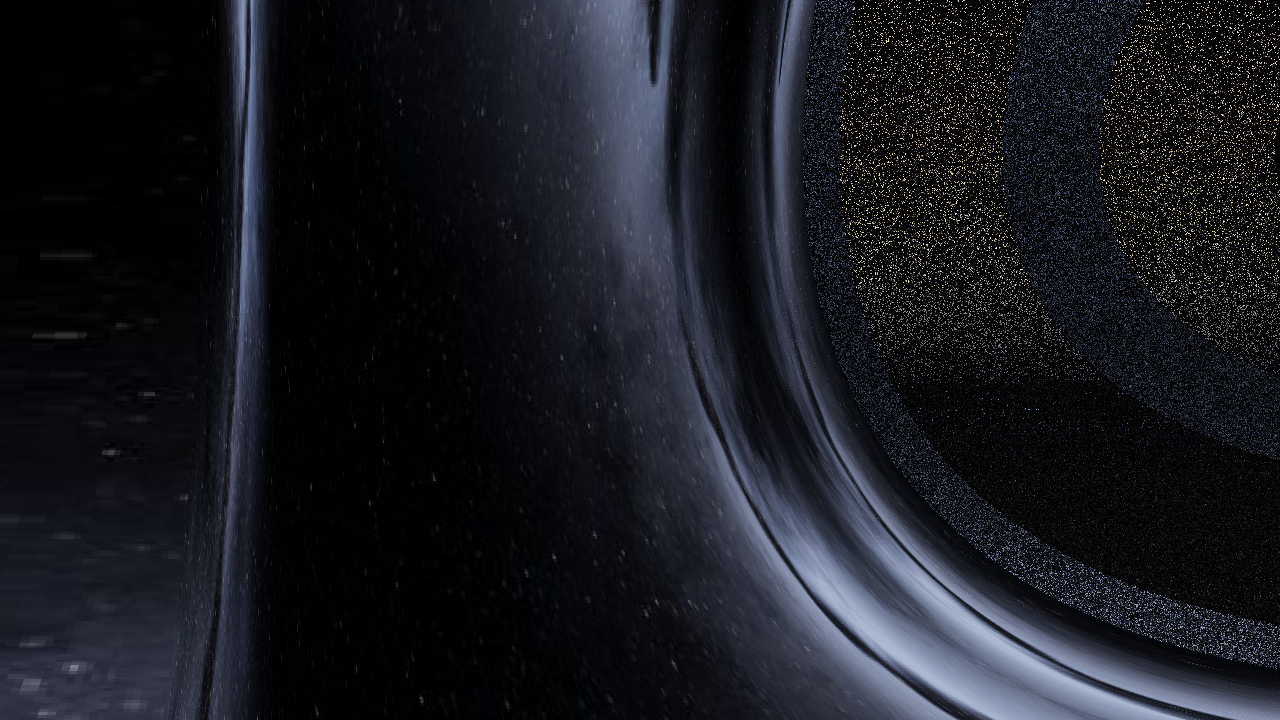

In [237]:
viewer.view_wormhole(phi0=np.pi*8/12, th0=np.pi*6/10, fov=np.pi*6/12, resolution=(1280,720))

In [ ]:
viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*7/10, fov=np.pi*6/12, resolution=(640*2,480*2))

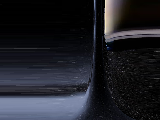

In [219]:
viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*7/10, fov=np.pi*7/12,resolution=(160,120))

In [221]:
img = viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*7/10, fov=np.pi*7/12, resolution=(1280,720))
img.show()

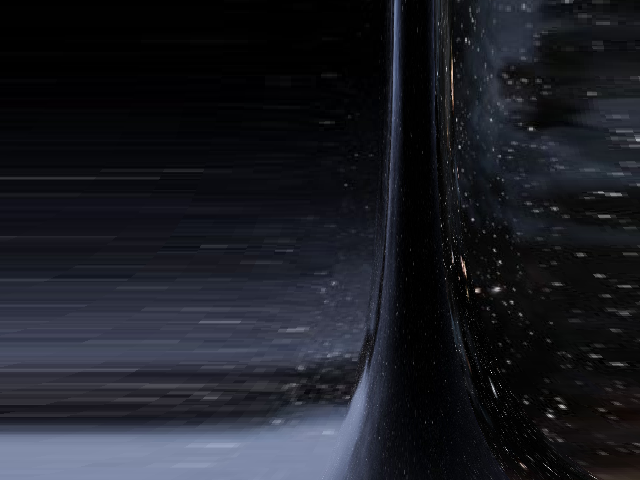

In [200]:
viewer.view_wormhole(phi0=np.pi*5/12, th0=np.pi*7/10, fov=np.pi*6/12)

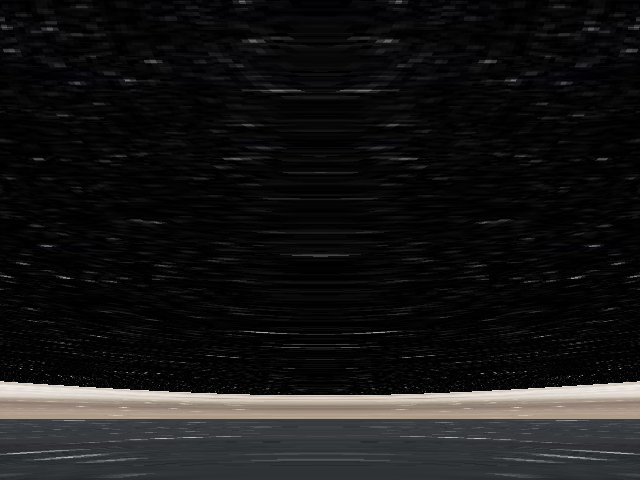

In [110]:
viewer.view_wormhole(phi0=np.pi, th0=np.pi*8/10, fov=np.pi*7/12)

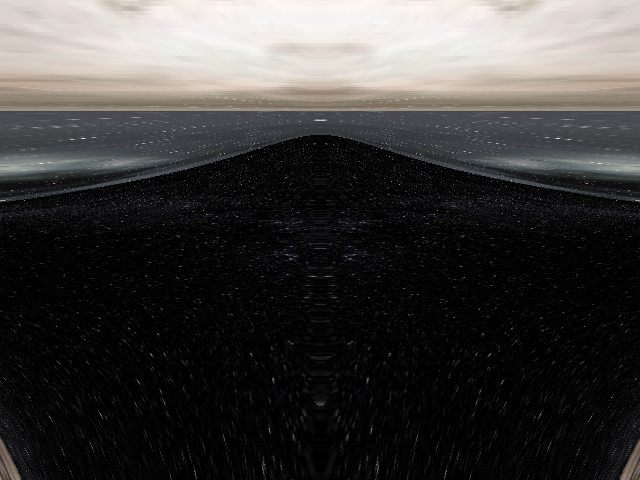

In [108]:
viewer.view_wormhole(phi0=np.pi, th0=np.pi*4/10, fov=np.pi*11/12)

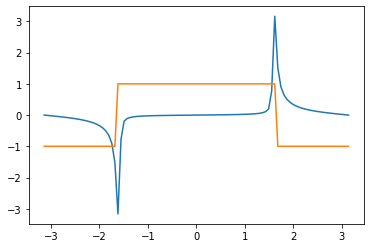

In [59]:
phi_arr = np.linspace(-np.pi, np.pi, 100)
y_arr = [viewer.f_phi(phi) for phi in phi_arr]
z_arr = [viewer.f_sl(phi) for phi in phi_arr]

plt.plot(phi_arr, y_arr)
plt.plot(phi_arr, z_arr)

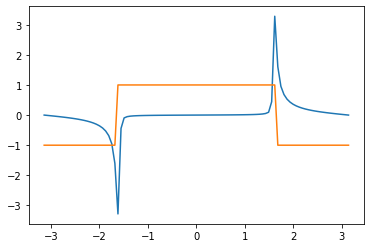

In [160]:
phi_arr = np.linspace(-np.pi, np.pi, 100)
y_arr = [viewer.f_phi(phi) for phi in phi_arr]
z_arr = [viewer.f_sl(phi) for phi in phi_arr]

plt.plot(phi_arr, y_arr)
plt.plot(phi_arr, z_arr)

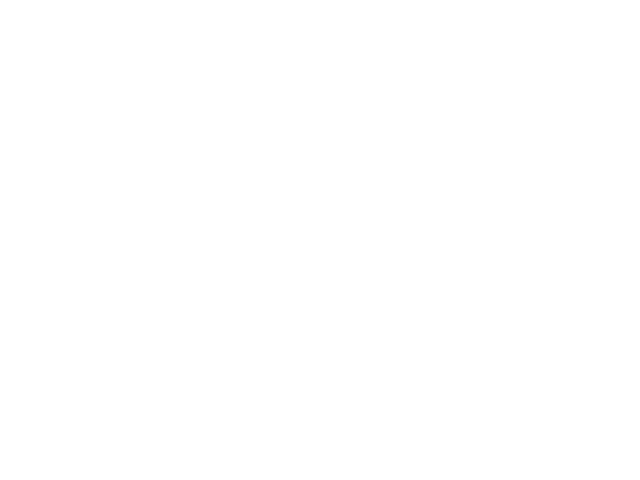

In [66]:
img

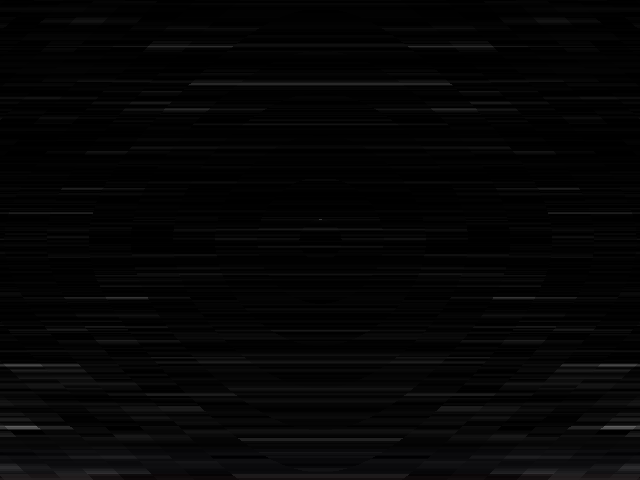

In [58]:
Image.fromarray(np.uint8(img))

In [57]:
img

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.]],

       [[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.]],

       ...,

       [[15., 11., 12.],
        [15., 11., 12.],
        [30., 26., 27.],
        ...,
        [30., 26., 27.],
        [30., 26., 27.],
        [15., 11., 12.]],

       [[27., 23., 24.],
        [27., 23., 24.],
        [27., 23., 24.],
        ...,
        [34., 30., 31.],
        [27., 23., 24.],
        [27., 23., 24.]],

       [[27., 23., 24.],
        [27., 23., 24.],
        [27., 23., 24.],
        ...,
        [27., 23., 24.],
        [27., 23., 24.],
        [27., 23., 24.]]